<a id="tercero"></a>
## 3. Clasificación en texto

Un problema muy complejo, en el cual actualmente se esta avanzando a pasos de gigantes en comparación con los avances de hace unos cuantos años, es en la comprehensión de texto, o de lenguaje natural en general. Nuestra manera de construir significado a partir de las palabras es mucho más compleja de lo que nos damos cuenta y supone un gran grado de conocimiento previo que hemos adquirido a lo largo de nuestras vidas. Lograr que una maquina de aprendizaje pueda extraer significado o interpretaciones a partir de un texto es un problema bastante actual, en el cual aún se hacen avances día a día. En esta pregunta utilizaremos una base de datos de texto, extraida de _reviews_ de peliculas en la página IMDB. Cada uno de estos _reviews_ esta etiquetado como positivo o negativo. Nuestra tarea será predecir esta etiqueta a partir de la secuencia de palabras encodeadas como frecuencias de cada ejemplo.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/6/6a/New-imdb-logo.png/1024px-New-imdb-logo.png"  style="height:6cm;"  />

Para esto probaremos distintas técnicas, incluyendo Perceptron, Redes densas _feed forward_ y ensamblados. Si bien ninguna de estas aproximaciones son las usualmente utilizadas en la actualidad para procesamiento de texto (_words embeddings_, redes recurrentes y redes convolucionales, entre muchos otros), esta pregunta servirá como una buena aproximación a las problematicas usualmente encontradas en estas técnicas y al momento de trabajar con texto. 

#### 3.a Carga de datos y preprocesamientos

Cargue los datos. Utilizaremos 45000 de los datos como entrenamiento y el resto como validación. Investigue sobre la base de datos en cuestión y la representación de los datos cargados: ¿qué representa cada entrada de `x_tr`?

Comente ligeramente sobre los parámetros `num_words` y `skip_top`. ¿Por qué podría ser deseable eliminar las palabras más comunes?

Utilize luego la función `vectorize_sequences` para transformar los inputs del modelo. ¿Qué realiza esta función? ¿Qué valor debería tener el parámetro `dimension` en este caso?  ¿Qué información perdemos y qué información preservamos en esta transformación?

#### Clasificación de sentimiento de comentarios de películas IMDB

Dataset de 50000 comentarios de películas de IMDB, etiquetados por sentimientos ( positivo/negativo). Los comentarios han sido pre-procesados, y cada comentario esta codificado como una secuencia de palabras indexadas (enteros). Por conveniencia, las palabras están indexadas por frecuencia general en el dataset, por ejemplo, el entero "3" codifica la tercera palabra mas frecuente en el dataset. Esto permite filtrar rapidamente, por ejemplo si se quiere considerar las 10.000 palabras mas comunes eliminando las 20 mas comunes. 

Como convención "0", no significa una palabra específica, si no se utiliza para codificar cualquier palabra desconocida

##### Retornos

- 2 tuplas : 
    - x_train , x_test : lista de secuencias, las cuales son listas de índices (enteros). Si el argumento
      `num_words` fue especificado, el máximo valor de indice posible es `num_words - 1`. Si el argumento             `maxlen` fue especificado, la secuencia mas larga posible es de largo `max_len``
    - y_train,y_test: lista de etiquetas enteras (1 o 0)
    
- Argumentos:
    - path : si no tienes la data localmente, será descargada a esta localización
    - num_word : Entero o None.Las palabras más frecuentes a tener en cuenta. Cualquier palabra menos                          frecuente aparecerá como valor oov_char en los datos de secuencia.
    - skip_top : Entero. Las palabras mas frecuentes a ignorar ( aparecerán como valor oov_char en la                          secuencia de la data
    - maxlen: Entero. Largo de máxima secuencia. Una secuencia más larga será truncada 
    - seed: Semilla para reproducir orden de la data
    - start_char: Entero. El inicio de una secuencia se marcará con este carácter. Se establece en 1                   porque 0 suele ser el carácter de relleno.
    - oov_char:Entero. Las palabras que fueron cortadas debido al límite num_words o skip_top serán                          reemplazadas con este carácter
    - index_from: Entero. Indice palabras reales con este índice y superiores. 
   
#### Eliminar palabras más comunes:
- Al eliminar las palabras más comunes se esta simplificando el texto ya que estas corresponderian a conectores       entre plabras las cuales no serian muy relevantes al momento de analizar el texto.

In [2]:
import numpy as np
import pandas as pd
from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


Using TensorFlow backend.


In [3]:
import numpy as np
# save np.load
np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)
n_words = 501
(x_tr, y_tr), (x_val, y_val)= imdb.load_data(num_words=n_words, skip_top=5)

np.load = np_load_old

**Comentario:** Al establecer los párametros "num_words y skip_top" se estan considerando las 500 palabras más comunes y se eliminan las 5 top.  

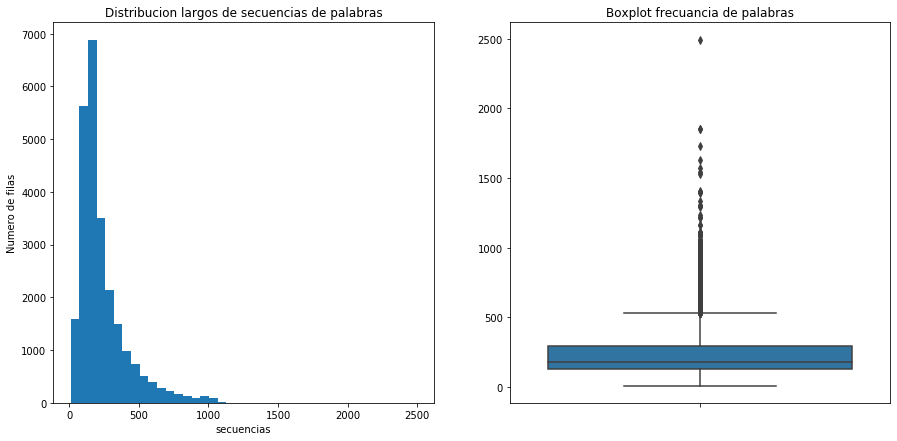

In [4]:
phrases_len = []
for row in x_tr:
    phrases_len.append(len(row))

plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
plt.hist(phrases_len, bins=40)
plt.xlabel("secuencias")
plt.ylabel("Numero de filas")
plt.title("Distribucion largos de secuencias de palabras")

plt.subplot(1,2,2)
sns.boxplot(phrases_len, labels=["Matriz frases"],orient='v')
plt.title("Boxplot frecuancia de palabras")
plt.show()

**Comentario :** Se observa que el largo de secuencias de palabra más frecuente en la data corresponde a un valor cercano a 200. El grueso de los datos se concentra en valores entre 0 a 500, quedando como outlaiers las secuencias  mayores a 500.

#### Se procede a concatenar las datas de train y validation para luego dividirlas en un 80 y 20 % respectivamente, evitando asi un posible ordenamiento que podria existir en las datas.

In [5]:
X = np.hstack((x_tr,x_val))
Y = np.hstack((y_tr,y_val))

In [6]:
X_train , X_val , Y_train , Y_val = train_test_split(X,Y,test_size=0.1)

In [7]:
len_secuen = []
for i in range (len(X_train)):
    len_secuen.append(len(X_train[i]))

In [8]:
max_len_sec=max(len_secuen)
print ('la secuencia más larga es igual a ')
print(max_len_sec)

la secuencia más larga es igual a 
2494


**Comentario :** Se observa que la secuencia más largo tiene un largo de 2494 caracteres.

In [9]:
frecuente = []
for i in range (len(X_train)):
    frecuente.append(max(X_train[i]))


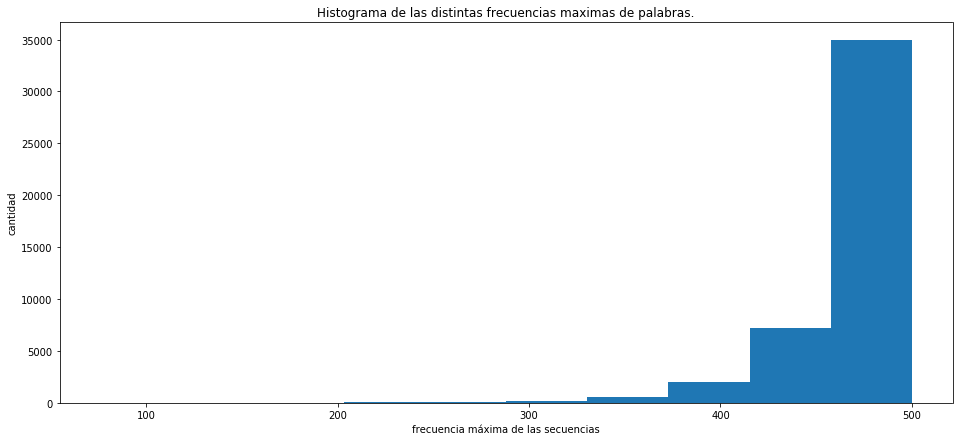

In [10]:
plt.figure(figsize=(16,7))
plt.hist(frecuente)
plt.title('Histograma de las distintas frecuencias maximas de palabras.')
plt.xlabel('frecuencia máxima de las secuencias')
plt.ylabel('cantidad')

plt.show()

**Comentario :** Se observa que la frecuancia máxima de palabras es 'num_words-1' = 500 como se había determiando anteriormente.

#### A continuación se procede a vectorizar las distintas secuencias de palabras:
- La dimensión debe ser igual al largo de la secuencia más larga.

In [11]:
def vectorize_sequences(sequences, dimension= n_words ):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

x_tr = vectorize_sequences(X_train)
x_val = vectorize_sequences(X_val)

#### funcion Vectorize_sequences :
- Esta función lo que realiza es reordenar las frases asignando un valor igual a 1 si esta presente y 0 en caso de que no lo este, ademas quedán todas las secuencias de igual dimensión.
- En base lo a dicho anteriormente se perderia el orden de las palabras

In [12]:
x_tr.shape

(45000, 501)

In [13]:
x_val.shape

(5000, 501)

In [14]:
data_tr = pd.DataFrame(x_tr)
data_tr['Y_train']= Y_train

In [15]:
data_vl = pd.DataFrame(x_val)
data_vl['Y_val']= Y_val

In [16]:
data_tr.describe()

,0,1,2,3,4,5,6,7,8,9,...,492,493,494,495,496,497,498,499,500,Y_train
count,45000.0,45000.0,45000.0,45000.0,45000.0,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,...,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000
mean,0.0,0.0,1.0,0.0,0.0,0.965911,0.966644,0.948511,0.939867,0.893756,...,0.035556,0.043844,0.043556,0.045156,0.043356,0.042933,0.038378,0.043933,0.029022,0.499733
std,0.0,0.0,0.0,0.0,0.0,0.181460,0.179565,0.220995,0.237736,0.308154,...,0.185181,0.204751,0.204106,0.207648,0.203658,0.202709,0.192109,0.204949,0.167871,0.500005
min,0.0,0.0,1.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,0.0,1.0,0.0,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.0,0.0,1.0,0.0,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.0,0.0,1.0,0.0,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,0.0,0.0,1.0,0.0,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [17]:
data_vl.describe()

,0,1,2,3,4,5,6,7,8,9,...,492,493,494,495,496,497,498,499,500,Y_val
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,...,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000
mean,0.0,0.0,1.0,0.0,0.0,0.967000,0.965600,0.950200,0.937000,0.901200,...,0.037600,0.047800,0.047200,0.040000,0.044000,0.043600,0.041200,0.04700,0.029000,0.502400
std,0.0,0.0,0.0,0.0,0.0,0.178654,0.182273,0.217553,0.242987,0.298423,...,0.190246,0.213364,0.212088,0.195979,0.205116,0.204224,0.198772,0.21166,0.167823,0.500044
min,0.0,0.0,1.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,0.0,0.0,1.0,0.0,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,0.0,0.0,1.0,0.0,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,1.000000
75%,0.0,0.0,1.0,0.0,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,1.000000
max,0.0,0.0,1.0,0.0,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000


**Comentario :** Se crean los DataFrame para facilitar la visualización de los resultados obtenidos con la función vectorize_sequences.

#### 3.b Perceptrón **(Opcional)**
Entrene un perceptrón con activación sigmoidea, optimizador _Stochastic Gradient Descent_, por a lo menos 15 _epochs_, como muestra el código siguiente. 

Discuta sobre la dimensión de `x_tr` y la cantidad de parámetros del modelo deacuerdo al método `.summary` del modelo. 

Grafique el error o el _accuracy_ segun su preferencia, tanto sobre entrenamiento como validación, a medida pasan los _epochs_. Note esta información puede obtenerla desde `history.history`.

In [24]:
from keras.models import Sequential
from keras.layers import Dense

In [46]:
per = Sequential()
per.add(Dense(1,activation='sigmoid'))
per.compile('sgd',loss='binary_crossentropy',metrics=['accuracy'])
history1 = per.fit(x_tr,Y_train, epochs=50, validation_data=(x_val,Y_val))
per.summary()

Train on 45000 samples, validate on 5000 samples
Epoch 1/50
45000/45000 [==============================] - 4s 78us/step - loss: 0.5684 - acc: 0.7179 - val_loss: 0.4887 - val_acc: 0.7980
Epoch 2/50
45000/45000 [==============================] - 3s 71us/step - loss: 0.4660 - acc: 0.7995 - val_loss: 0.4389 - val_acc: 0.8218
Epoch 3/50
45000/45000 [==============================] - 3s 62us/step - loss: 0.4324 - acc: 0.8134 - val_loss: 0.4175 - val_acc: 0.8260
Epoch 4/50
45000/45000 [==============================] - 3s 65us/step - loss: 0.4152 - acc: 0.8209 - val_loss: 0.4034 - val_acc: 0.8296
Epoch 5/50
45000/45000 [==============================] - 3s 69us/step - loss: 0.4043 - acc: 0.8246 - val_loss: 0.3950 - val_acc: 0.8324
Epoch 6/50
45000/45000 [==============================] - 3s 67us/step - loss: 0.3967 - acc: 0.8286 - val_loss: 0.3900 - val_acc: 0.8358
Epoch 7/50
45000/45000 [==============================] - 3s 75us/step - loss: 0.3912 - acc: 0.8300 - val_loss: 0.3844 - val_acc:

In [49]:
train_loss1 = history1.history['loss']
val_loss1 = history1.history['val_loss']

In [79]:
history1.history['val_acc']

[0.798,
 0.8218,
 0.826,
 0.8296,
 0.8324,
 0.8358,
 0.8388,
 0.8406,
 0.8392,
 0.8452,
 0.8444,
 0.846,
 0.8452,
 0.845,
 0.846,
 0.8454,
 0.8462,
 0.846,
 0.8468,
 0.847,
 0.8464,
 0.846,
 0.845,
 0.8452,
 0.8454,
 0.8456,
 0.846,
 0.8452,
 0.8456,
 0.846,
 0.8456,
 0.846,
 0.8452,
 0.8452,
 0.846,
 0.8444,
 0.845,
 0.8452,
 0.8458,
 0.8456,
 0.8456,
 0.8456,
 0.8444,
 0.8456,
 0.841,
 0.8462,
 0.846,
 0.8438,
 0.8444,
 0.8462]

In [51]:
epocas1 = np.arange(50)+1

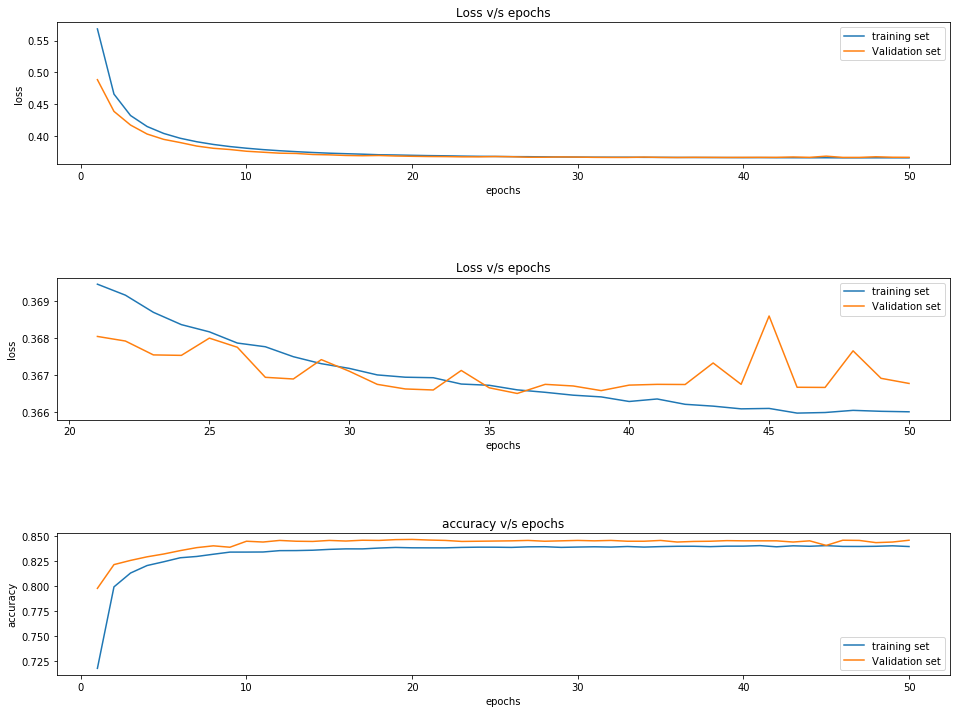

In [84]:
plt.figure(figsize=(16,12))

plt.subplot(3,1,1)
plt.plot(epocas1,train_loss1)
plt.plot(epocas1,val_loss1)
plt.legend(["training set","Validation set"])
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("Loss v/s epochs")

plt.subplot(3,1,2)
plt.plot(epocas1[20:],train_loss1[20:])
plt.plot(epocas1[20:],val_loss1[20:])
plt.legend(["training set","Validation set"])
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("Loss v/s epochs")

plt.subplot(3,1,3)
plt.plot(epocas1,history1.history['acc'])
plt.plot(epocas1,history1.history['val_acc'])
plt.legend(["training set","Validation set"])
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title("accuracy v/s epochs")

plt.subplots_adjust( hspace=0.8)





#### Comentario :
- Se observa un underfitting al comienzo, esto se debe a que la red esta comenzando a calibrarse lo que explica que se obtengan errores de validación menores que de train al comienzo, ya pasado los 30 epochs esto se comeinza a regularizar.
- Esta red cuenta con 502 parametros entrenables.

#### 3.c Red con una capa oculta
Ahora, haremos nuevamente un modelo secuencial, al cual le agregarémos una capa oculta con activación ReLu. ¿Qué realiza la función ReLu (puede ejemplificar con gráficos)?

Entrene esta red nuevamente con los mismos parámetros que la red anterior. ¿Mejoran los desempeños? ¿Cuál es el número de parámetros de este modelo? Grafíque nuevamente como varía la métrica a medida pasan las _epochs_. ¿Alcanza a notar sobreajuste?

Cambie la función de activación por otra de su elección (e.g. $tanh$ o activación lineal). ¿Cambia el desempeño? 

Compare finalmente el desempeño con una regresión logistica. ¿Cómo hace la red para obtener representaciones no-lineales que la regresión lineal no puede obtener? ¿Por qué se podría argumentar que una red neuronal densa _feed forward_ tiene un sabor a ensamblado de regresiones lineales en un principio? 

In [53]:
model = Sequential()
model.add(Dense(64, activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.compile('sgd',loss='binary_crossentropy',metrics=['accuracy'])
history2 = model.fit(x_tr,Y_train ,epochs=50,validation_data=(x_val,Y_val))
model.summary()

Train on 45000 samples, validate on 5000 samples
Epoch 1/50
45000/45000 [==============================] - 5s 106us/step - loss: 0.5514 - acc: 0.7226 - val_loss: 0.4392 - val_acc: 0.8042
Epoch 2/50
45000/45000 [==============================] - 4s 83us/step - loss: 0.4143 - acc: 0.8159 - val_loss: 0.3885 - val_acc: 0.8314
Epoch 3/50
45000/45000 [==============================] - 4s 86us/step - loss: 0.3862 - acc: 0.8295 - val_loss: 0.3754 - val_acc: 0.8396
Epoch 4/50
45000/45000 [==============================] - 4s 86us/step - loss: 0.3769 - acc: 0.8344 - val_loss: 0.3795 - val_acc: 0.8366
Epoch 5/50
45000/45000 [==============================] - 4s 91us/step - loss: 0.3728 - acc: 0.8362 - val_loss: 0.3716 - val_acc: 0.8390
Epoch 6/50
45000/45000 [==============================] - 4s 92us/step - loss: 0.3706 - acc: 0.8382 - val_loss: 0.3730 - val_acc: 0.8386
Epoch 7/50
45000/45000 [==============================] - 4s 99us/step - loss: 0.3697 - acc: 0.8377 - val_loss: 0.3835 - val_acc

In [54]:
epocas2 = np.arange(50)+1
train_loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']

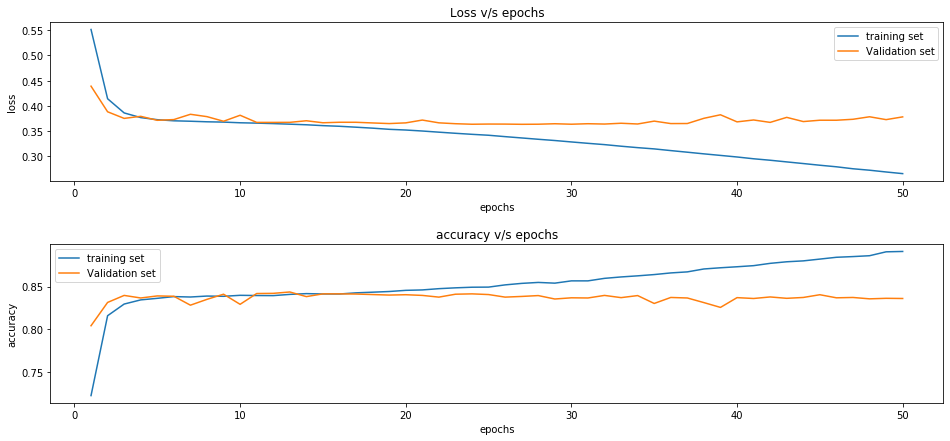

In [86]:
plt.figure(figsize=(16,7))

plt.subplot(2,1,1)
plt.plot(epocas2,train_loss2)
plt.plot(epocas2,val_loss2)
plt.legend(["training set","Validation set"])
plt.title("Loss v/s epochs")
plt.xlabel("epochs")
plt.ylabel("loss")

plt.subplot(2,1,2)
plt.plot(epocas1,history2.history['acc'])
plt.plot(epocas1,history2.history['val_acc'])
plt.legend(["training set","Validation set"])
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title("accuracy v/s epochs")

plt.subplots_adjust( hspace=0.4)

plt.show()

**Comentario :** Se observa del gráfico un claro overfitting del modelo pasado la epochs = 20 aproximadamente.El mejor modelo seria cercano a la epochs 15.

In [88]:
print("min_val_perc")
print(max(history1.history['val_acc']))
print("")
print("min_val_relu ")
print(max(history2.history['val_acc']))


min_val_perc
0.847

min_val_relu 
0.8436


**Función Relu**

La función Relu se define como:

$$f(x)=max(0,x)$$

Su comportamiento lo podemos visualizar con el siguiente gráfico

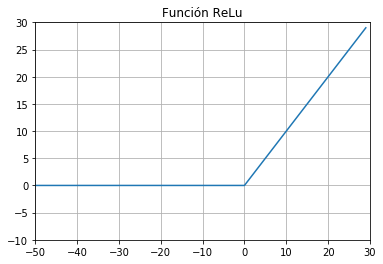

In [58]:
x0 = np.zeros(50)
x1 = np.arange(30)
x3 = np.hstack((x0,x1))
x4 = np.linspace(-50,29,80)
plt.plot(x4,x3)
plt.title("Función ReLu")
plt.ylim(-10,30)
plt.xlim(-50,30)
plt.grid()


#### La función reLu más conocida como rectificador lineal, lo que hace es una especie de dropout, asignando salida igual a cero para entradas con valor negativo y retorna el mismo valor de salida para entradas con valor positivo.

**Ajustando una Regresión Logística**

In [62]:
from sklearn.linear_model import LogisticRegression
import pandas as pd
from sklearn.metrics import mean_squared_error as MSE

In [60]:
lr_model = LogisticRegression(solver='lbfgs')
lr_model.fit(x_tr,Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [61]:
prediccion = lr_model.predict(x_val)
print("Accuracy:",accuracy_score(Y_val,prediccion))

Accuracy: 0.8452


In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
print(confusion_matrix(prediccion,Y_val))

#### Comparación de resultados perceptrón; Reed deep reLu y LogisticRegression
|Modelo      |N° Parámetros|Val_acc  |
|:-----------|:------------|:---------|
|Perceptron  |502  |0.847|
|Deep_reLu   |32128 + 65|0.8436|
|LogisticRegression||0.8452|

**Comentario :** El desempeño obtenido por la reed deep con función de activación reLu es peor que el obtenido por el perceptron . El modelo de LogisticRegression presenta un desempeño parecido a los anteriores, pero se debe considerar el bajo tiempo de entrenamiento de esta lo cual le da ventaja sobre los modelos de redes que hemos entrenado.

#### 3.d Exploración de número de neuronas ocultas

Utilizando la misma estructura de la red entrenada en la pregunta anterior, evalue como varía el _accuracy_ sobre validación y entrenamiento a medida se cambia el numero de neuronas. Explore numeros de neuronas en potencias de 2 entre 2 y 256. En cada iteración debe considerar el mejor _accuracy_ sobre validación y el _accuracy_ de entrenamiento de ese mísmo _epoch_, pues ese sería el modelo que se preferiría. 

Grafique como variaron los _accuracy_ a medida cambió el número de neuronas y discuta. 

In [18]:
from keras.models import Sequential
from keras.layers import Dense
best_accu_val = []
best_accu_tr = []
for i in range(1,9):
    model = Sequential()
    model.add(Dense(units=2**i,activation='relu'))
    model.add(Dense(1,activation='sigmoid'))
    model.compile('sgd',loss='binary_crossentropy',metrics=['accuracy'])
    history = model.fit(x_tr,Y_train ,epochs=20,verbose = 0,validation_data=(x_val,Y_val));
    best_accu_val.append(max(history.history['val_acc']))
    best_accu_tr.append(max(history.history['acc']))
    

W0912 22:27:33.620718 140321910515520 deprecation_wrapper.py:119] From /home/lenovo/.conda/envs/machinelearning/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0912 22:27:33.640508 140321910515520 deprecation_wrapper.py:119] From /home/lenovo/.conda/envs/machinelearning/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0912 22:27:33.658856 140321910515520 deprecation_wrapper.py:119] From /home/lenovo/.conda/envs/machinelearning/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0912 22:27:33.661261 140321910515520 deprecation_wrapper.py:119] From /home/lenovo/.conda/envs/machinelearning/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.rando

In [49]:
pesos_entrada_red = pd.DataFrame(model.layers[0].get_weights()[0])
pesos_entrada_red.to_csv('pesos_entrada_red.csv')
pesos_entrada_red = pd.read_csv('pesos_entrada_red.csv',index_col=0, parse_dates=True)

In [50]:
pesos_entrada_red.head()

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
0,0.070547,0.086465,-0.074030,-0.042799,0.032985,0.045781,0.028339,0.023477,0.012786,0.079925,...,-0.020723,0.059466,-0.073724,-0.024370,0.055961,-0.060922,0.019946,-0.050930,0.043653,-0.025002
1,-0.004665,-0.005426,-0.067639,0.039401,-0.023217,0.036499,0.061895,-0.018536,0.028100,0.087733,...,-0.029863,-0.009923,-0.057591,-0.012692,-0.067376,-0.078239,-0.010123,-0.059220,0.012584,0.039547
2,0.007188,0.058395,0.025441,0.047838,-0.073585,0.091412,0.047697,-0.020655,-0.030393,0.046692,...,0.024868,0.078999,0.051706,-0.034449,-0.036288,-0.011194,-0.049125,0.033731,-0.050527,-0.042578
3,-0.026467,-0.024285,0.078389,-0.057970,-0.082330,-0.032413,-0.021962,0.084088,0.073401,-0.081760,...,0.078064,0.046162,0.015040,-0.067600,-0.059301,0.049450,-0.018737,0.076936,0.032101,-0.076666
4,-0.001998,0.011971,0.082586,-0.080156,-0.034278,0.006547,0.062565,-0.026774,0.061547,-0.010342,...,-0.025405,0.082675,-0.041203,0.034460,0.065023,0.012745,0.031798,0.016014,0.044716,-0.006430


In [19]:
best_accu_val

[0.8436, 0.8454, 0.846, 0.8424, 0.8446, 0.8442, 0.847, 0.8436]

In [20]:
best_accu_tr

[0.8410444444444445,
 0.8411555555555555,
 0.8390888888888889,
 0.8430888888888889,
 0.8439777777777778,
 0.8462444444444445,
 0.8492,
 0.8548666666666667]

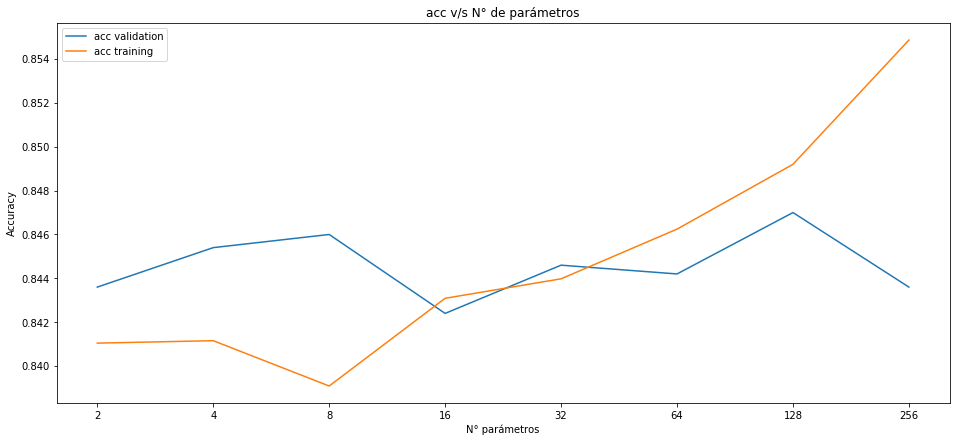

In [21]:
plt.figure(figsize=(16,7))
param = ["2","4","8","16","32","64","128","256"]
plt.plot(param,best_accu_val,)
plt.plot(param,best_accu_tr)
plt.legend(["acc validation","acc training"])
plt.title("acc v/s N° de parámetros")
plt.xlabel("N° parámetros")
plt.ylabel("Accuracy")

plt.show()

#### De lo observado se pordría considerar que el mejor numero de parametros para la capa oculta es un valor cercano a 128 como el modelo entrenado anteriormente, despues de este valor el modelo comienza a experimentar un claro overfitting ya que logra memorizar de mejor manera l

#### Se guarda el mejor modelo obtenido.

In [22]:
data_numero_deep = pd.DataFrame(history.history)

In [23]:
data_numero_deep.to_csv('data_numero_deep.csv')

In [24]:
data_numero_deep = pd.read_csv('data_numero_deep.csv', index_col=0, parse_dates=True)
data_numero_deep

,val_loss,val_acc,loss,acc
0,0.441156,0.8040,0.547485,0.728778
1,0.388527,0.8306,0.415578,0.814911
2,0.373547,0.8390,0.386544,0.829178
3,0.370285,0.8436,0.375926,0.835022
4,0.373933,0.8346,0.371100,0.837044
5,0.392955,0.8212,0.368168,0.839978
6,0.375904,0.8334,0.366000,0.840800
7,0.374512,0.8354,0.364227,0.841200
8,0.374559,0.8346,0.362577,0.842578
9,0.367037,0.8408,0.360452,0.843444


#### 3.e Pesos de la red

Obtenga los pesos de la red entrenada a completitud anteriormente usando el método `.get_weights` y grafíque un historgrama. Note que para cada capa se obtienen por separado los pesos de los datos y del intercepto. Así en el índice 0 obtenemos los pesos de los datos de entrada, en el 1 los pesos del intercepto de entrada, en el 2 los pesos de la capa oculta y en el 3 los pesos del intercepto de la capa oculta. Solo se requiere graficar el primero.

Compare luego ese histograma con el obtenido al graficar los pesos de una red sin entrenar, como muestra el código. Discuta lo que observa. 

In [25]:
from keras.optimizers import SGD
untrained = Sequential()
untrained.add(Dense(128, activation='relu'))
untrained.add(Dense(1,activation='sigmoid'))
untrained.compile(SGD(lr=0.001),loss='binary_crossentropy',metrics=['accuracy'])
untrained.fit(x_tr,Y_train,epochs=0)  # the easy way to create the weights without training, though there are more purists ways


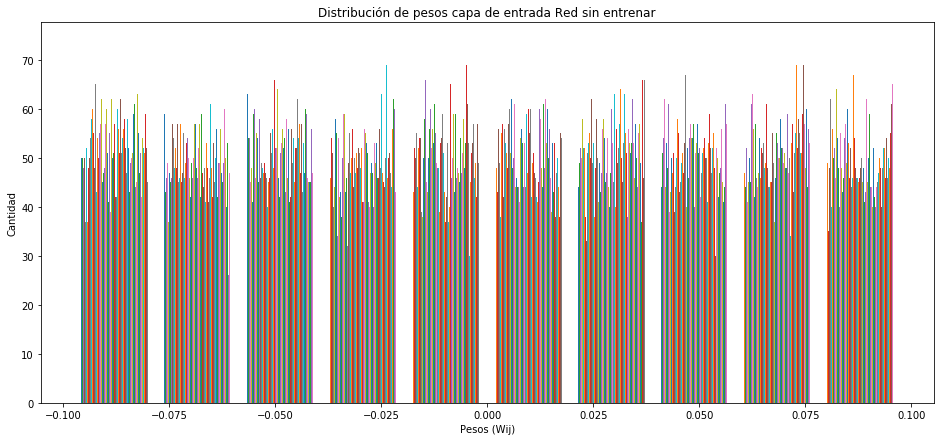

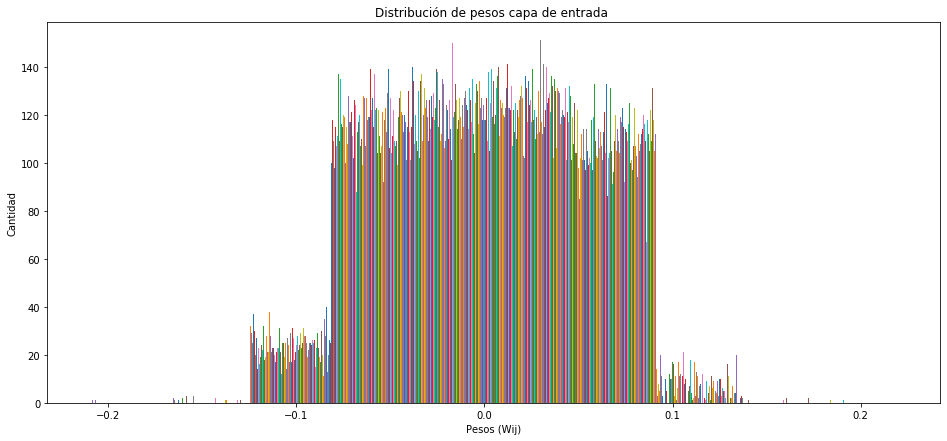

In [34]:
plt.figure(figsize=(16,7))
plt.hist(untrained.get_weights()[0])
plt.xlabel('Pesos (Wij)')
plt.ylabel('Cantidad')
plt.rcParams["figure.figsize"]= [16,7]
plt.title('Distribución de pesos capa de entrada Red sin entrenar')
plt.show 

for i in range(1):
    plt.figure(figsize=(16,7))
    plt.hist(model.layers[i].get_weights()[0],rwidth=1)
    plt.xlabel('Pesos (Wij)')
    plt.ylabel('Cantidad')
    plt.rcParams["figure.figsize"]= [16,7]
    plt.title('Distribución de pesos capa de entrada ')
    plt.show()

**Comentario :** Se puede observar de los histogramas que al comienzo, los pesos de entrada se distribuyen de manera uniforme en un rango de valore [-0.1 , 0.1], con esto se consigue que el modelo explore en un mayor espacio de busqueda. Una vez entrenada la red estos pesos se van hacercando más a cero, y muy pocos valores superan el rango inicial de pesos, con lo cual se estarian eliminando atributos de la red.

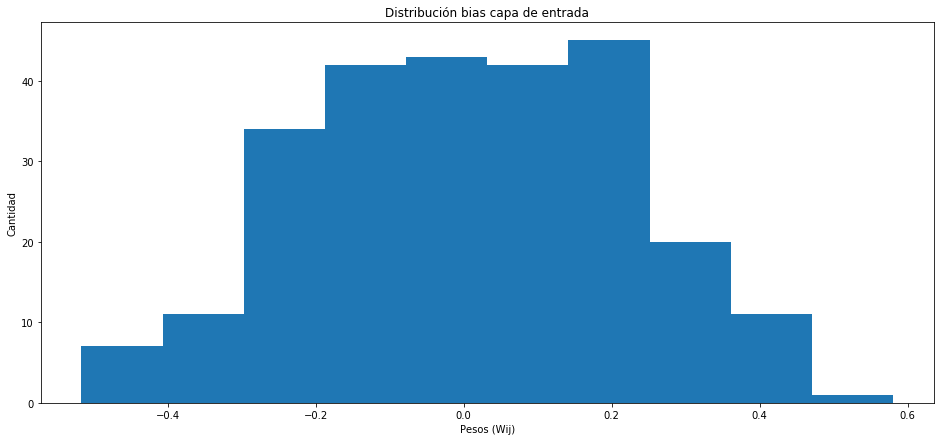

In [36]:
for i in range(1,2):
    plt.figure(figsize=(16,7))
    plt.hist(model.layers[i].get_weights()[0],rwidth=1)
    plt.xlabel('Pesos (Wij)')
    plt.ylabel('Cantidad')
    plt.rcParams["figure.figsize"]= [16,7]
    plt.title('Distribución bias capa de entrada')
    plt.show()

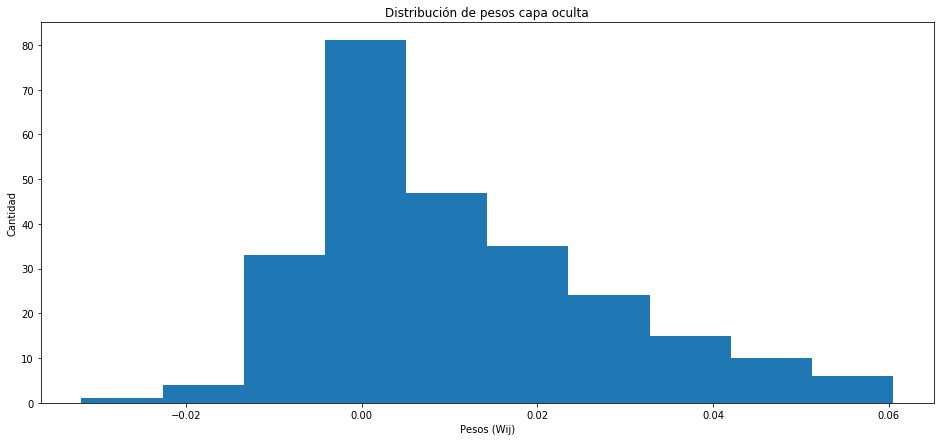

In [37]:
for i in range(1):
    plt.figure(figsize=(16,7))
    plt.hist(model.layers[i].get_weights()[1],rwidth=1)
    plt.xlabel('Pesos (Wij)')
    plt.ylabel('Cantidad')
    plt.rcParams["figure.figsize"]= [16,7]
    plt.title('Distribución de pesos capa oculta')
    plt.show()

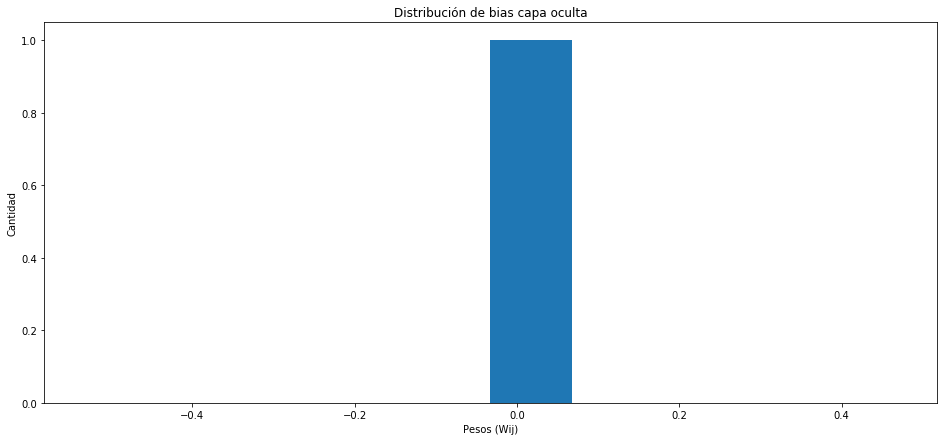

In [38]:
for i in range(1,2):
    plt.figure(figsize=(16,7))
    plt.hist(model.layers[i].get_weights()[1],rwidth=1)
    plt.xlabel('Pesos (Wij)')
    plt.ylabel('Cantidad')
    plt.rcParams["figure.figsize"]= [16,7]
    plt.title('Distribución de bias capa oculta')
    plt.show()

#### 3.h Bagging **(Opcional)**

Crearemos ahora un ensamblado utilizando la técnica de _Bagging_, ensamblando las predicciones de distintos árboles para predecir el resultado. 

Explique brevemente el procedimiento realizado por _Bagging_, en particular por qué los distintos arboles no se entrenan idénticamente y el significado de los parámetros que aparecen en el código. 

In [59]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=2),
                        n_estimators=100,
                        max_samples=0.5,
                        max_features=0.7
                       )
bag.fit(x_tr,Y_train) 

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None,
                                                        criterion='gini',
                                                        max_depth=2,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort=False,
                                                        random_state=None,
                                                        splitter='best'),
       

In [62]:
print('score modelo bagging tree (max_depth =2)')
print(bag.score(x_val,Y_val))


score modelo bagging tree (max_depth =2)
0.6764


#### Resultados bagging tree (max_depth = 20)

In [57]:
print('score modelo bagging tree')
print(bag.score(x_val,Y_val))


score modelo bagging tree
0.7984


#### 3.i AdaBoost
_Adaptative Boosting_ o AdaBoost es otro meta-algoritmo que crea ensamblados a partir de modelos más simple. Entrene un modelo de AdaBoost con estimador "pequeño", por ejemplo puede usar un arbol, una regresión lineal u otros modelos de `sklearn` y un límite de estimadores (`n_estimators`) de a lo menos 200. 

Calcule su _accuracy_ y comparelo con los demás métodos. 

In [58]:
from sklearn.ensemble import AdaBoostClassifier
adaboost = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2), n_estimators=200)
adaboost.fit(x_tr,Y_train)
                              

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(class_weight=None,
                                                         criterion='gini',
                                                         max_depth=2,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort=False,
                                                         random_state=None,
                             

In [63]:
print('score modelo adaboost tree (max_depth = 2)')
print(adaboost.score(x_val,Y_val))


score modelo adaboost tree (max_depth = 2)
0.828


**Comentario :** Adaboost tree siendo el mejor modelo encontrado presenta un desempeño menor al obtenido por el perceptron al comienzo (acc_val = 0,847), LogisticRegression (acc_val = 0.8452) igual obtiene un mejor desempeño que adaboost_tree (score _val = 0.828).

Discuta sobre el modelo que encontró el mejor `accuracy`. ¿Por qué cree que esta representación le acomoda a la red neuronal y no a los arboles de desición? 